In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
%pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.3 MB 8.1 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.3 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 8.8 MB/s  0:00:00

   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   --------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),     # resize (MNIST already 28x28; kept for requirement)
    transforms.ToTensor(),           # converts to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # normalization
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train into train/validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 2.54MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 110kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 930kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.57MB/s]


In [6]:
# Prepare flattened data for Logistic Regression
X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1) / 255.0
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1) / 255.0
y_test = test_dataset.targets.numpy()

log_reg = LogisticRegression(max_iter=200,)
log_reg.fit(X_train, y_train)

pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)

print("Logistic Regression Test Accuracy:", round(acc_lr, 4))

Logistic Regression Test Accuracy: 0.9266


C:\Users\Lenovo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


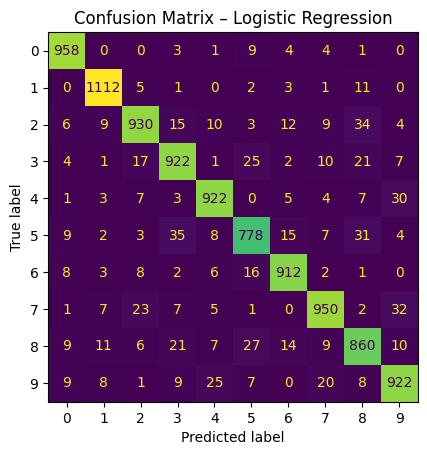

In [7]:
cm_lr = confusion_matrix(y_test, pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(colorbar=False)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(5):
    # Train
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_acc = correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Acc=0.9061, Val Acc=0.9798
Epoch 2: Train Acc=0.9742, Val Acc=0.9838
Epoch 3: Train Acc=0.9822, Val Acc=0.9898
Epoch 4: Train Acc=0.9856, Val Acc=0.9896
Epoch 5: Train Acc=0.9868, Val Acc=0.9904


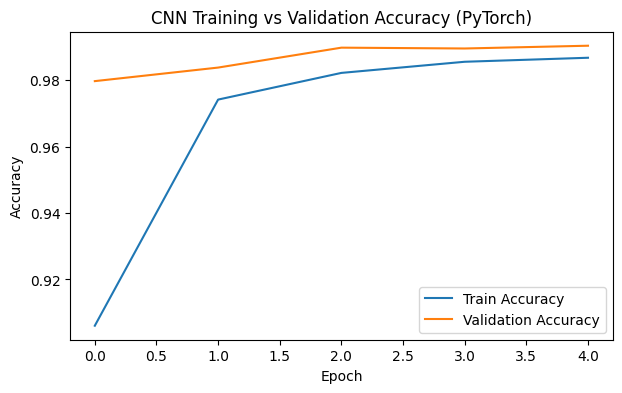

In [14]:
plt.figure(figsize=(7,4))
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Validation Accuracy")
plt.title("CNN Training vs Validation Accuracy (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

CNN Test Accuracy: 0.9894


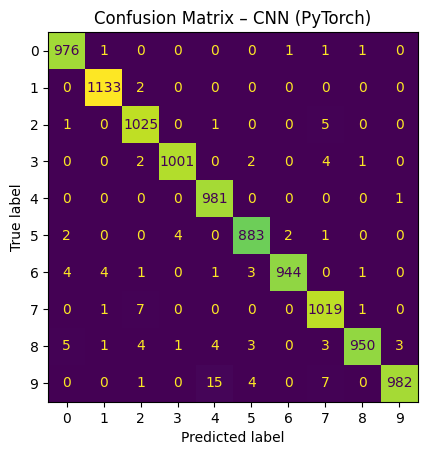

In [11]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

acc_cnn = accuracy_score(all_labels, all_preds)
print("CNN Test Accuracy:", round(acc_cnn, 4))

cm_cnn = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm_cnn).plot(colorbar=False)
plt.title("Confusion Matrix – CNN (PyTorch)")
plt.show()

In [15]:
import pandas as pd

pd.DataFrame({
    "Model": ["Logistic Regression", "CNN (PyTorch)"],
    "Test Accuracy": [acc_lr, acc_cnn]
})

,Model,Test Accuracy
0,Logistic Regression,0.9266
1,CNN (PyTorch),0.9894
